# HW2 - Lucas Kanade 

Pablo Agustin Ortega Kral (portegak)

In [2]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Download data

In this section we will download the data and setup the paths.


In [3]:
# Download the data
os.makedirs('data', exist_ok=True)
if not os.path.exists('data/carseq.npy'):
    !wget https://www.cs.cmu.edu/~deva/data/carseq.npy -O data/carseq.npy
if not os.path.exists('data/girlseq.npy'):
    !wget https://www.cs.cmu.edu/~deva/data/girlseq.npy -O data/girlseq.npy

# Q2.1: Theory Questions (5 points)
Please refer to the handout for the detailed questions.

## Q2.1.1: What is $\frac{\partial \mathbf{W}(\mathbf{x};\mathbf{p})}{\partial \mathbf{p}^{T}}$? (**Hint**: It should be a 2x2 matrix)


**A:**

Describes the rate of change of the warping function respect to the warp parameters. In the case of a pure translation $W(x;p) = x + p$

$$ W(x;p) =  \begin{bmatrix}
    W_x(x;p)\\
    W_y(x;p)
\end{bmatrix} = \begin{bmatrix}
    x + p_1 \\
    y + p_2
\end{bmatrix} = \vec{x} + \vec{p}$$

$$\frac{\delta W}{\delta p} = \begin{bmatrix}
\frac{\partial W_x}{\partial p_1} & \frac{\partial W_x}{\partial p_2} \\
\frac{\partial W_y}{\partial p_1} & \frac{\partial W_y}{\partial p_2}
\end{bmatrix} = \begin{bmatrix}
1 & 0 \\
0 & 1
\end{bmatrix} $$




## Q2.1.2: What is $\mathbf{A}$ and $\mathbf{b}$?

**A:** 

In short, **A represents the image gradient multiplied by the rate of change of the warping function respect the warp parameters (jacobian). A will have size $ x \times p $, where x is the number of pixels in the template and p the number of transformation parameters.** and **b represents the error between the original template and the warped template with current parameters**.

In Lucas Kanade alligment we aim to find the warp parameters minimize the least square error between the orginal template and the transformed template in the target frame. Considering the image as $I$, a two dimensional pixel coordinate as the vector $x$ and the warping function associated with parameterss $p$, we have that 

$$ \text{min}_{p} \sum_{x} \left[ \underset{\text{Warped image}}{I(W(x;p))} - \underset{\text{Template}}{T(x)} \right]^2 $$


To simplify the problem, we assume that given a small enough change (or a good enough initial guess) we can solve this by solving for an increment in the warping parameters $\Delta p$

$$ \text{min}_{\Delta p} \sum_{x} \left[ \underset{\text{Warped image}}{I(W(x;p + \Delta p))} - \underset{\text{Template}}{T(x)} \right]^2 $$

Linearizing with Taylor Series and rearraging for convineace 

$$ \text{min}_{\Delta p} \sum_{x}  \left[ \underset{\text{Image gradient} }{\nabla I} \underset{\text{Jacobian}}{\frac{\delta W}{\delta p}} \Delta p - \underset{\text{Template offset}}{\left( T(x) - I(W(x;p)) \right)}   \right]$$


Organizing in vector form, 

$$ \text{min}_{\Delta p} \sum_{x} \left[A \Delta p - b \right] ^2$$


## Q2.1.3 What conditions must $\mathbf{A}^{T}\mathbf{A}$ meet so that a unique solution to $\Delta \mathbf{p}$ can be found?


**A**: It must be invertible, ie. $A$ is a non-singular matrix.


# Q2.2: Lucas-Kanade (20 points)
Make sure to comment your code and use proper names for your variables.

In [4]:
from scipy.interpolate import RectBivariateSpline

def LucasKanade(It, It1, rect, threshold, num_iters, p0=np.zeros(2), debug=False):
    """
    :param[np.array(H, W)] It   : Grayscale image at time t [float]
    :param[np.array(H, W)] It1  : Grayscale image at time t+1 [float]
    :param[np.array(4, 1)] rect : [x1 y1 x2 y2] coordinates of the rectangular template to extract from the image at time t,
                                  where [x1, y1] is the top-left, and [x2, y2] is the bottom-right. Note that coordinates
                                  [floats] that maybe fractional.
    :param[float] threshold     : If change in parameters is less than thresh, terminate the optimization
    :param[int] num_iters       : Maximum number of optimization iterations
    :param[np.array(2, 1)] p0   : Initial translation parameters [p_x0, p_y0] to add to rect, which defaults to [0 0]
    :return[np.array(2, 1)] p   : Final translation parameters [p_x, p_y]
    """
    def get_jacobian(x, y, transform_type='affine'):
        if transform_type == 'affine': # This means the are 6 warp parameters
            jacobian = [
                [x, 0 ,y ,0, 1, 0],
                [0, x, 0, y, 0, 1]
            ]
        else: # Assume translation only (2 warp parameters)
            jacobian = [
                [1, 0],
                [0, 1]
            ]
        return np.array(jacobian, dtype=np.float32)
    
    # Initialize variables
    p = p0 # Warp parameters
    spline_t0 = RectBivariateSpline(np.arange(It.shape[0]), np.arange(It.shape[1]), It)
    spline_t1 = RectBivariateSpline(np.arange(It1.shape[0]), np.arange(It1.shape[1]), It1)

    # Precompute image gradients   
    I_dy = np.gradient(It1, axis=0)
    I_dx = np.gradient(It1, axis=1)
    grad_spline_dx = RectBivariateSpline(np.arange(It1.shape[0]), np.arange(It1.shape[1]), I_dx)
    grad_spline_dy = RectBivariateSpline(np.arange(It1.shape[0]), np.arange(It1.shape[1]), I_dy)
    
    # Adjust the rect coordinates
    x1, y1, x2, y2 = rect
    rec_x = np.arange(x1, x2+1)
    rec_y = np.arange(y1, y2+1)
    X, Y = np.meshgrid(rec_x, rec_y)
    template_t0 = spline_t0.ev(Y, X) # Sample the template from It
    if debug:
        plt.figure()
        plt.imshow(template_t0, cmap='gray')
        plt.title('Template at t0')
        plt.show()
        plt.close() 

    # Iterate over num_iters
    for i in range(num_iters):
        # Warp the image
        warped_y, warped_x = Y + p[1], X + p[0]

        # Sample template
        template_t1 = spline_t1.ev(warped_y, warped_x) # Sample the template from It1

        # Build system A
        # 1) by computing the Jacobian
        J = get_jacobian(x=None, y=None, transform_type='translation')
        # 2) by computing the gradient of the image
        dx = grad_spline_dx.ev(warped_y, warped_x).flatten()
        dy = grad_spline_dy.ev(warped_y, warped_x).flatten()
        image_grad = np.vstack([dx, dy]).T
        # 3) by computing the product of the Jacobian and the gradient
        A = image_grad @ J

        # Build b by computing the error
        b = (template_t0 - template_t1).flatten()
        
        delta_p, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
            
        p[0] +=  delta_p[0]
        p[1] +=  delta_p[1]
        if np.linalg.norm(delta_p) <= threshold:
            break
    return p

## Debug Q2.2



A few tips to debug your implementation:
- Feel free to use and modify the following snippet to debug your implementation. The snippet simply visualizes the translation resulting from running LK on a single frame. You should be able to see a slight shift in the template.

- You may also want to visualize the image gradients you compute within your LK implementation

- Plot iterations vs the norm of delta_p

In [5]:
def draw_rect(rect,color):
    w = rect[2] - rect[0]
    h = rect[3] - rect[1]
    plt.gca().add_patch(patches.Rectangle((rect[0],rect[1]), w, h, linewidth=1, edgecolor=color, facecolor='none'))


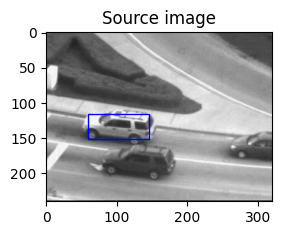

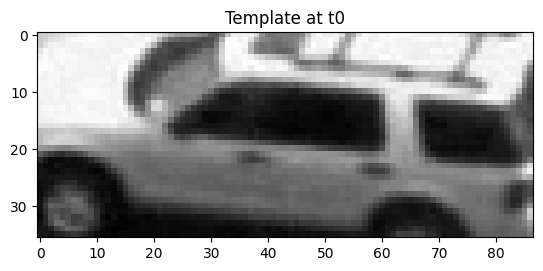

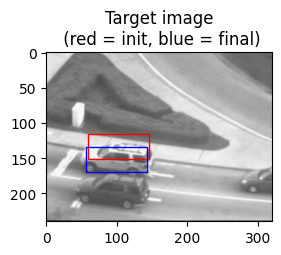

In [6]:
num_iters = 100
threshold = 0.01
debug = True

seq = np.load("data/carseq.npy")
rect = [59, 116, 145, 151]
It = seq[:,:,0]

# Source frame
plt.figure()
plt.subplot(1,2,1)
plt.imshow(It, cmap='gray')
plt.title('Source image')
draw_rect(rect,'b')

# Target frame + LK
It1  = seq[:,:, 20] 
p = LucasKanade(It, It1, rect, threshold, num_iters, p0=np.zeros(2), debug=debug)
plt.subplot(1,2,2)
plt.imshow(It1, cmap='gray')
plt.title('Target image\n (red = init, blue = final)')
rect_t1 = rect + np.concatenate((p,p))
draw_rect(rect,'r')
draw_rect(rect_t1,'b')


## Q2.3: Tracking with template update (15 points)

In [7]:
def TrackSequence(seq, rect, num_iters, threshold):
    """
    :param seq       : (H, W, T), sequence of frames
    :param rect      : (4, 1), coordinates of template in the initial frame. top-left and bottom-right corners.
    :param num_iters : int, number of iterations for running the optimization
    :param threshold : float, threshold for terminating the LK optimization
    :return: rects   : (T, 4) tracked rectangles for each frame
    """
    H, W, N = seq.shape

    rects = []
    rects.append(rect.copy())   
    # Iterate over the car sequence and track the car
    for i in tqdm(range(seq.shape[2]-1)):
        frame_0 = seq[:,:,i]
        frame_i = seq[:,:,i+1]
        assert not np.all(frame_0 == frame_i), "The frames are the same"
        p = LucasKanade(frame_0, frame_i, rect, threshold, num_iters)
        rect = rect + np.concatenate((p,p))
        rects.append(rect)
    rects = np.array(rects)
    assert rects.shape == (N, 4), f"Your output sequence {rects.shape} is not ({N}x{4})"
    return rects

### Q2.3 (a) - Track Car Sequence

Run the following snippets. If you have implemented LucasKanade and TrackSequence function correctly, you should see the box tracking the car accurately. Please note that the tracking might drift slightly towards the end, and that is entirely normal.

Feel free to play with these snippets of code by playing with the parameters.

In [8]:
def visualize_track(seq,rects,frames):
    # Visualize tracks on an image sequence for a select number of frames
    plt.figure(figsize=(15,15))
    for i in range(len(frames)):
        idx = frames[i]
        frame = seq[:, :, idx]
        plt.subplot(1,len(frames),i+1)
        plt.imshow(frame, cmap='gray')
        plt.axis('off')
        draw_rect(rects[idx],'b');

100%|██████████| 414/414 [00:07<00:00, 53.39it/s]


[[ 59.         116.         145.         151.        ]
 [ 59.40176921 117.12830647 145.40176921 152.12830647]
 [ 58.90196676 118.05798013 144.90196676 153.05798013]
 ...
 [ 72.43341788 141.0574134  158.43341788 176.0574134 ]
 [ 73.73562262 142.30271994 159.73562262 177.30271994]
 [ 75.26807225 142.83458934 161.26807225 177.83458934]]


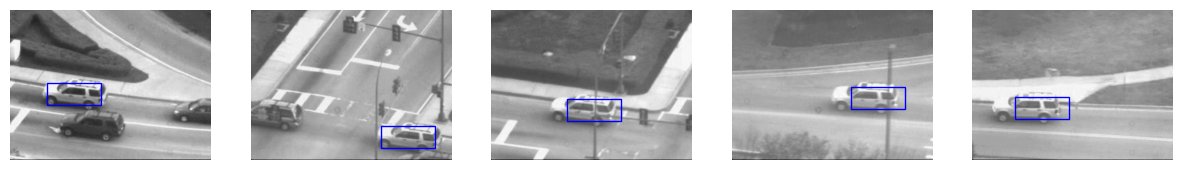

In [9]:
seq = np.load("data/carseq.npy")
rect = [59, 116, 145, 151]

# NOTE: feel free to play with these parameters
num_iters = 100
threshold = 0.01

rects = TrackSequence(seq, rect, num_iters, threshold)

visualize_track(seq,rects,[0, 79, 159, 279, 409])
print(rects)


### Q2.3 (b) - Track Girl Sequence

Same as the car sequence.

100%|██████████| 89/89 [00:07<00:00, 11.83it/s]


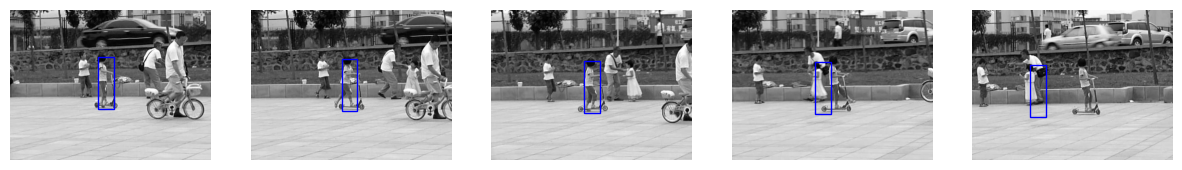

In [10]:
# Loads the squence
seq = np.load("data/girlseq.npy")
rect = [280, 152, 330, 318]

# NOTE: feel free to play with these parameters
num_iters = 10000
threshold = 0.01

rects = TrackSequence(seq, rect, num_iters, threshold)

visualize_track(seq,rects,[0, 14, 34, 64, 84])